### 確率プログラミング

多くなモデルで閉じた形式の解析的な事後分布が求められないために確率プログラミングが必要です。確率プログラミングは複雑なモデルを構築する有効なライブラリがPyMC3です。

事後分布が解析的に解けない場合でも、それを計算するいくつかの方法が存在します。それらの方法のいくつかを示します。

1. 非マルコフ的方法
　 - グリッドコンピューティング　（Grid computing）
  - 2次近似(quadratic approximation)
  - 変分法(variational method)
 
 
2.  マルコフ的方法
   - メトロポリスーヘイステイングス
   - ハミルトニアンモデカルロ/ノーUターンサンプラー
   


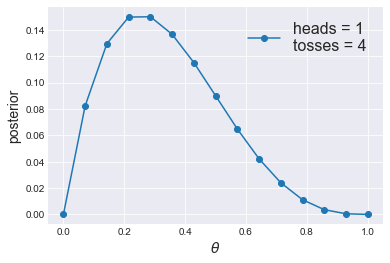

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
plt.style.use('seaborn-darkgrid')

def posterior_grid(grid_points=100, heads=6, tosses=9):
    """
    A grid implemetation for the g coin-flip problem
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(5, grid_points)    
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

points = 15
h, n = 1, 4
grid, posterior = posterior_grid(points, h, n)

plt.plot(grid, posterior, 'o-', label='heads = {} \ntosses = {}'.format(h, n))
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('posterior', fontsize=14)
plt.legend(loc=0, fontsize=16)

#### 非マルコフ的方法

- 2次近似
ラブラス法(Laplace method)や正規近似としても知られ、正規分布によって事後分布を近似することを指します。事後分布の最頻値の周辺をを正規分布として近似することです。

- 変分法
大きなデータセットの場合、マルコフ的な方法は遅く、必要な速度を実現できない場合があるます。あまりに計算が困難な尤度に関して、変分法はより良い選択となり得ます。加えて、これらの方法は、MCMCの初期値として事後分布の高速な近似を与えるために有益です。変分法の一般的なアイデアは、単純な分布を使って事後分布を近似することにあります。

#### マルコフ的方法
MCMC法として知られる一連の方法が存在します。グリッドコンピューティングの項で見たように、与えられた点に関して尤度と事前分布を計算する必要があります。これによって事後分布の全体を近似したいのです。MCMC法はグリッドコンピューティングより優れた結果をもたらします。というのも、それらは低い確率の領域より高い確率の領域に多くの時間留まるように設計されているからです。実際、あるMCMC法はパラメータの相対的な確率に応じてパラメータ空間の異なる領域を探索してくれます。領域Aが領域Bの2倍の確率であるなら、Bからのサンプルの2倍のサンプルをAから抽出します。従って、解析的に全ての事後分布を計算することが不可能な場合でもl私達はMCMC法を使うことでそこからサンプリングすることができ、サンプルサイズが大きくなればより良い結果を得ることができます。

- MCMC(MonteCarlo MarkovChain)
モンテカルロの由来は乱数を使用するためです。関心のある数量を計算するためにモンテカルロ法を使うという古典的な教示例は、円周率$\pi$の計算です。


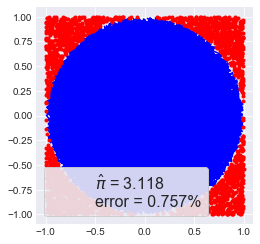

In [4]:
N = 10000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum() * 4/N
error = abs((pi - np.pi)/pi) * 100

outside = np.invert(inside)

plt.plot(x[inside], y[inside], 'b')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label='$\hat\pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9, fontsize=16)

### マルコフ連鎖

マルコフ連鎖が、一連の状態とそれらの状態間のせんいを表す一組の確率によって構成される数学的なオブジェクトです。**次の状態へ遷移する確率が現在の状態のみ依存しているとき、その連鎖はマルコフ的です**。このような連鎖を所与とし、出発点を選び、遷移確率に従ってたの状態に遷移することで、ランダムウォークを実現することができます。サンプリングしたい分布(ベイジアン分析においては事後分布)に比例する遷移を持ったマルコフ連鎖を見つけることができるなら、サンプリングはこの連鎖における状態間の遷移問題となります。事後分布を知らない場合、この連鎖はどのよにしたら見つけることができるでしょう？それは詳細つりあい条件(detailed balance condition)として知られます。直感的には、この条件は逆方向に動けるはずであることを教えてくれます（物理学において可逆過程は一般的な考え方です）。すなわち、状態$i$から状態$j$に遷移する確率は、状態$j$から状態$i$に遷移する確率と同じになります。

まとめると、詳細つりあいを充分満足するマルコフれんさをなんとか作り出せるなら、正しい分布からサンプルを得ることを保証してくれ、そしてその連鎖からサンプリングすることができるのです。詳細つりあいを保証する最も一般的な方法はMetropolis-Hastings algorithmです。任意の分布から確率$p(x)$でサンプリングすることができます。アルゴリズムの詳細は次のようなステップがあります。

1. 関心のあるパラメータ$x_i$の初期値を選びます、これはランダムに行ったり、ある種の考察の元決めたりします。
2. 新しいパラメータの値$x_{i+1}$を決め、例えば正規分布や一様分布など、サンプリングが簡単な分布$Q(x_{i+1}|x_{i})$からサンプルを得ます。これは状態$x_i$をかき乱すステップとして理解できます。
3. メトロポリスーヘイスティングスの基準
$
    p_a(x_{i+1}|x_{i}) = min(1, \frac{p(x_{x+1})q(x_i|x_{i+1})}{p(x_i)q(x_{i+1}|x_i)})
$

を使って、新しいパラメータの値を受け入れる確率を計算することができます。

4. 上記3で計算された確率が区間[0,1]の一様分布から得られる値より大きい場合、新しい状態を受容し、そうでなければ古い状態に止まります。
5. 充分なサンプルを得られるまで上記2から4を繰り返します。何を持って十分であるかは、後に検討します。

いくつか考慮すべきことがあります。

-  提案分布$Q(x_{i+1}|x_{i})$（サンプリングの際、ランダムに動き回る点が次に移動する先の候補となる点を提案する分布）が対称性を持つ場合、**Metropolis criteria**と呼ばれる

　　$
  　　　  p_a(x_{i+1}|x_{i}) = min(1, \frac{p(x_{x+1})}{p(x_i)})
　　$

を得ます。なお、この式ではヘイスティングス部分が除かれまています。

- ステップ3と4は、最もありそうな状態、すなわち最もありそうなパラメータ値を受け入れたり移動したりすることを意味しています。ありそうにないパラメータの値は、新しいパラメータの値$x_{i+1}$の確率とうるいパラメータの値$x_i$の確率の比例によって確率的に受容されます。この受容ステップの基準は、正確なサンプリングを保証しながら、グリッド近似より効率的なサンプルを与えてくれます。

- 目標分布(ベイズ統計学では事後分布)は、サンプリングされたパラメータ値を保存することによって近似されます。新しい状態$x_{i+1}$への移動を受容する場合は、サンプリングされた$x_{i+1}$を保存します。$x_{i+1}$への移動を棄却する場合は、$x_i$の値を保存します。


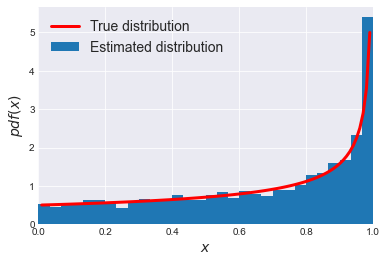

In [10]:
def metropolis(func, steps=10000):
    """A simple metropolis implementation"""
    samples = np.zeros(steps)
    old_x = func.mean()
    old_prob = func.pdf(old_x)
    
    for i in range(steps):
        new_x = old_x + np.random.normal(0, 0.5)
        new_prob = func.pdf(new_x)
        acceptance = new_prob/old_prob
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            samples[i] = old_x
    return samples

func = stats.beta(1, 0.5)
samples = metropolis(func=func)
x = np.linspace(0.01, 0.99, 100)
y = func.pdf(x)

plt.xlim(0,1)
plt.plot(x, y, 'r-', lw=3, label='True distribution')
plt.hist(samples, bins=30,  density=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)